### My elaboration of Andrej's lecture

In [69]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np
from IPython.display import Image
# So we can see the output of multiple variables in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# data I/O
# input.txt should be simple plain text file with letters/chars
data = open('input-revised.txt', 'r').read() 
# data = 'hello\n'
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data_size %d characters, and vocab_size %d (unique).' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 150 # size of hidden layer of neurons
seq_length = 50 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias
pass;

data_size 26920 characters, and vocab_size 87 (unique).


Wxh.shape (150, 87)
Whh.shape (150, 150)
Why.shape (87, 150)
bh.shape (150, 1)
by.shape (87, 1)


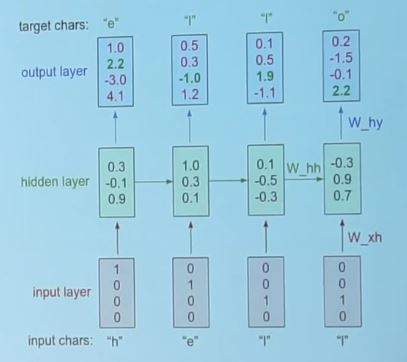

In [70]:
print('Wxh.shape', Wxh.shape)
print('Whh.shape', Whh.shape)
print('Why.shape', Why.shape)
print('bh.shape',bh.shape)
print('by.shape',by.shape)
Image('img/flow-chart-1.JPG', width=300)

### What's going into the Loss Function?
* `inputs`
* `targets`
* `hprev`

inputs size -> 50 
[16, 48, 60, 64, 56, 17, 50, 50, 64, 77, 3, 49, 60, 64, 3, 50, 64, 50, 36, 56, 77, 3, 9, 60, 68, 9, 9, 9, 68, 29, 36, 23, 23, 3, 68, 82, 48, 64, 7, 60, 17, 48, 74, 68, 54, 12, 49, 29, 3, 48]

targets size -> 50 
[48, 60, 64, 56, 17, 50, 50, 64, 77, 3, 49, 60, 64, 3, 50, 64, 50, 36, 56, 77, 3, 9, 60, 68, 9, 9, 9, 68, 29, 36, 23, 23, 3, 68, 82, 48, 64, 7, 60, 17, 48, 74, 68, 54, 12, 49, 29, 3, 48, 54]

hprev.shape (150, 1)
hprev [[ 1.         -1.         -1.          0.99997922  1.          0.99983974
  -0.99999539 -1.          0.99999739 -0.99999902 -0.99602007  0.99999968
   1.         -0.99999993  0.99999997 -0.99915413  0.99999997 -1.
  -0.98532799  0.95786175 -0.99999997 -1.          1.         -0.99915208
  -0.98106009  0.9999995  -1.         -0.99999598 -1.          0.99982434
  -0.99998814 -0.99999999 -0.9556855   0.99947389  1.         -0.99999831
  -1.          0.9186016  -0.99999984 -0.99999995 -0.98572794  0.9924949
   0.98851432 -0.99999997  0.99977644 -1.

(array([ 66.,   4.,   1.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   3.,   1.,   4.,  63.]),
 array([ -1.00000000e+00,  -9.60000000e-01,  -9.20000000e-01,
         -8.80000000e-01,  -8.40000000e-01,  -8.00000000e-01,
         -7.60000000e-01,  -7.20000000e-01,  -6.80000000e-01,
         -6.40000000e-01,  -6.00000000e-01,  -5.60000000e-01,
         -5.20000000e-01,  -4.80000000e-01,  -4.40000000e-01,
         -4.00000000e-01,  -3.60000000e-01,  -3.20000000e-01,
         -2.80000000e-01,  -2.40000000e-01,  -2.00000000e-01,
         -1.60000000e-01,  -1.20000000e-01,  -8.00000000e-02,
         -4.00000000e-02,  -6.58362254e-14,   4.00000000e-02,
          8.00000000e-02,   1.20000000e-01,   1.60000000e-01,
          2.00000000e-01,   2.40000000

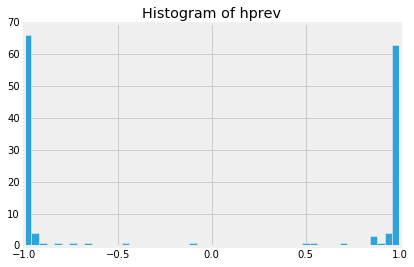

In [94]:
# run this after you've run the `Main Loop`
print('inputs size -> {} \n{}\n'.format(len(inputs), inputs))
print('targets size -> {} \n{}\n'.format(len(targets), targets))
print('hprev.shape', hprev.shape)
print('hprev', hprev.T)
%matplotlib inline
plt.hist(hprev, bins=50); plt.title('Histogram of hprev')

### Loss Function
#### Forward and Backward Pass

In [57]:
def lossFun(inputs, targets, hprev, debug=False):
    """
    inputs --> is a list of integers repesenting chars
    targets --> is a list of integers repesenting chars+1
    the above is a list that "slides" over the text document
    hprev --> is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs = {} # is the one hot encoded matrix that makes up our chars array 5x5
    hs = {} # hidden state matrix. `
    ys = {} # holds logtis output in array 100x1
    ps = {} # holds softmax probs in array 100x1
    hs[-1] = np.copy(hprev) # holds the hidden layer elements
    loss = 0
    
    ''' FORWARD PASS -- compute loss '''
    if debug:
        print('length of inputs = ', len(inputs))
        print('length of targets = ', len(targets))
        print('length of hprev = ', len(hprev))
    for t in range(len(inputs)):
        # encode in 1-of-k representation
        xs[t] = np.zeros((vocab_size,1))
        xs[t][inputs[t]] = 1
        # hidden state.
        # (100x100 * 100x1) + (100x5 * 5x1)      + (100x1) = 
        hs[t] = np.tanh(np.dot(Whh, hs[t-1]) + np.dot(Wxh, xs[t]) + bh)
        # Logits
        ys[t] = np.dot(Why, hs[t]) + by
        # probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) 
        # softmax (cross-entropy loss)
        if debug:
            print('t = ', t)
            print('ps[t]\n', ps[t])
            print('targets[t]\n', targets[t])
        loss += -np.log(ps[t][targets[t], 0]) 
        
    ''' BACKWARD PASS -- compute param gradient '''
    # store the weights gradients in matrices
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    # store the bias gradients in matrices
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    # ?
    dhnext = np.zeros_like(hs[0])
    
    for t in reversed(range(len(inputs))):
        # copy the array of already-computed softmax probablities
        dy = np.copy(ps[t])
        
        ''' backprop into y '''
        # remember that targets is a list of char-indices?
        dy[targets[t]] -= 1 
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        ''' backprop into h '''
        dh = np.dot(Why.T, dy) + dhnext
        ''' backprop through tanh nonlinearity '''
        dhraw = (1 - hs[t] * hs[t]) * dh
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        # clip to mitigate exploding gradients
        np.clip(dparam, -5, 5, out=dparam) 
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

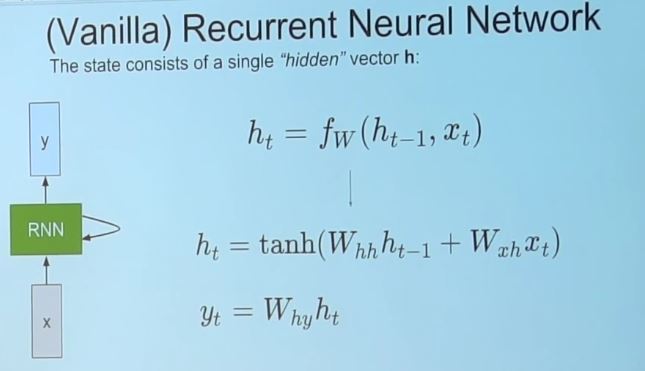

In [5]:
Image('img/hidden-vector.JPG', width=300)

### Sample some chars

In [6]:
def sample(h, seed_ix, n):
    """
    sample a sequence of integers from the model
    `h` is memory state
    `seed_ix` is seed letter for first time step
    n is the number of chars to pick from
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

### Main Loop

<IPython.core.display.Javascript object>


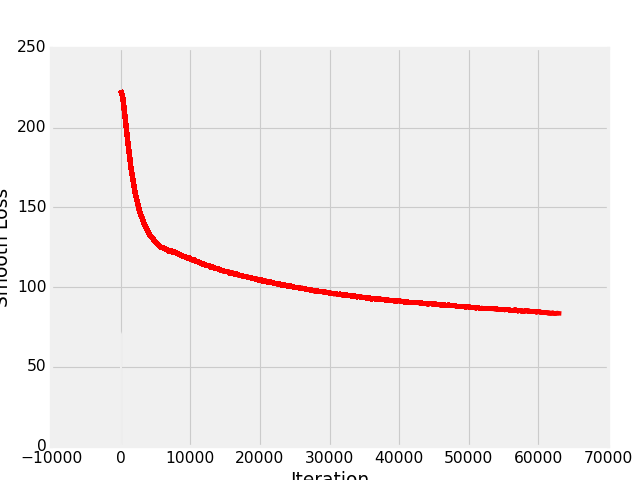

iter 0, loss: 223.29541110860484, loss_avg 223.29541110860484, improvement 0.0%
----
 ]Z,A"ruZi'"4P1^	A1Wox
0Dt G9Sj	8J$Rq-	]?VWa&Dzo…TK#…gP1?"$·1kG[a3)"	4md2
^40!WtSm$'Rl&0I0R[|SWtyB0['S8vbr…Ji)-dB4E6ezDU4t=P^-8 aA$MH&h-34n6.JW(Lk'Fywe',vpopx#Hk,pOeF-A !o2gkys·!i(rgjJQ:ef,/=svHKS0GRpb 
iter 15000, loss: 109.75343145725586, loss_avg 111.73319736310248, improvement 1.7718690170593787147624%
----
 38
Nupled.

Uhhing

I Thatly arlatvy..
DAR 22 MeMdy?
I wact fute tadd.
Omg
MAR 3T Mmmmmmmmhmkmmmmmm

AR q1awe ko
Mhmmm

ko to mm ardy 20T, 9:27:18TH, 8:36PR 4Khpdamer t??
houe
Dat'wharr

Okd ingos yay 
iter 30000, loss: 96.19176305960832, loss_avg 97.237410135502, improvement 1.0753547162934058434303%
----
 nkes

OFR 11:38PM

!!?
Oo. Bah.
3h
Mmmmmmmmmn?
Yal nitly ine met thally Khaleesi herdalld tomgut Tors  ?!!!

Mmmmmmm
???
sine sul gack MoD
Momm? man
Whal Bten trond on
APS

Oh lezedree tot ondd Fgo st 
iter 45000, loss: 89.24596489835271, loss_avg 89.79019596183164, improvement 0.60611412821

In [72]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import deque
import sys

# initializations
n = 0 # iteration counter
p = 0 # data pointer
deque_loss = deque(maxlen=10)

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) 
# loss at iteration 0
smooth_loss = -np.log(1.0/vocab_size)*seq_length # about 40

x, y = [], []
def pltsin(ax, _x, _y):
    x.append(_x)
    y.append(_y)
    ax.plot(x, y, 'r')
    fig.canvas.draw()

# setup up plot
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1,1)
ax.set_xlabel('Iteration')
ax.set_ylabel('Smooth Loss')

time  = time.time()
while True:
    '''
    PREPARE INPUTS
    (we're sweeping from left to right in steps seq_length long in the variable storing all the chars, `data`
    we have to go through the entire document of chars. but not all at once!
    here, we are splittings it up based on a constant length `seq_length`. this is like the replay memory
    it's like loading up the list, `inputs`, with chars
    then we load a corresponding list, `targets`, with chars that directly follow (or suppose to follow)
    the chars in `inputs`.
    Example: if data is 'hello', and a seq_length is `3`, then the first list of `inputs` is
    ['h','e','l'] and the `targets` list is ['e','l','l']. see how the `e` in `targets` follows the `h` in `inputs`?
    '''
    if p+seq_length+1 >= len(data) or n == 0:
        # reset RNN memory -> 100x1 of zeros
        hprev = np.zeros((hidden_size, 1)) 
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p    : p+seq_length]] # data[0 : 0+25]
    targets = [char_to_ix[ch] for ch in data[p+1 : p+seq_length+1]] # data[0+1 : 0+25+1]

    # sample from the model now and then
    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
#         print('----\n %s \n----' % (txt, ))

    '''
    LOSS
    forward seq_length characters through the net and fetch gradient
    hprev is the hidden state vector. So we're going in batches of 25 and we are
    keeping track of the hidden state vector at the end of your 25 letters so when 
    we feed the next batch, we can feed this hidden vector hprev as the initial H at
    that time step -- we're only doing backprop those 25 time steps.
    '''
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 300 == 0:
        deque_loss.append(smooth_loss)
        loss_avg = np.average(deque_loss)
        improve = abs((smooth_loss - loss_avg) / loss_avg) * 100
        if improve < 0.05 and (n > 500):
            print('BREAKING!')
            break
        pltsin(ax, n, smooth_loss)

        # sample
        if n % 5000 == 0:
            sample_ix = sample(hprev, inputs[0], 200)
            txt = ''.join(ix_to_char[ix] for ix in sample_ix)
            print('iter {}, loss: {}, loss_avg {}, improvement {:2.23}%'.format(n, smooth_loss, loss_avg, improve)) # print progress
            print('\r----\n {} \n----'.format(txt), end='\r')
            
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                  [dWxh, dWhh, dWhy, dbh, dby],
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

print("DONE!")
pass;